In [393]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.circuit.library import QFT
from math import gcd
import numpy as np
from IPython.display import display
%matplotlib inline

# Quantum Shor's Algorithm

In [394]:
N = 15 # number to factorize
n = np.ceil(np.log2(N)).astype(int) # number of bits to represent N
q = QuantumRegister(2*n, "q") # input qubits
t = QuantumRegister(n, "t") # target qubits
c = ClassicalRegister(2*n, "c") # classical bits

In [395]:
a = np.random.randint(2, N) # number possibly coprime with N
while gcd(a, N) > 1:
    a = np.random.randint(2, N)
print(f"Chosen base a = {a}")

Chosen base a = 11


Uf is a unitary transformation that compute the modular exponentiation of a number 'a' raised to the power of 2^i mod N, with i ranging from 0 to 2n-1. The unitary transformation is defined as:

In [396]:
def Uf(circ):
    for i in range(2*n):
        mod_exp = pow(a, 2**i, N)
        circ.cp(2*np.pi*mod_exp/N, q[i], t)

#### Quantum order-finding procedure:

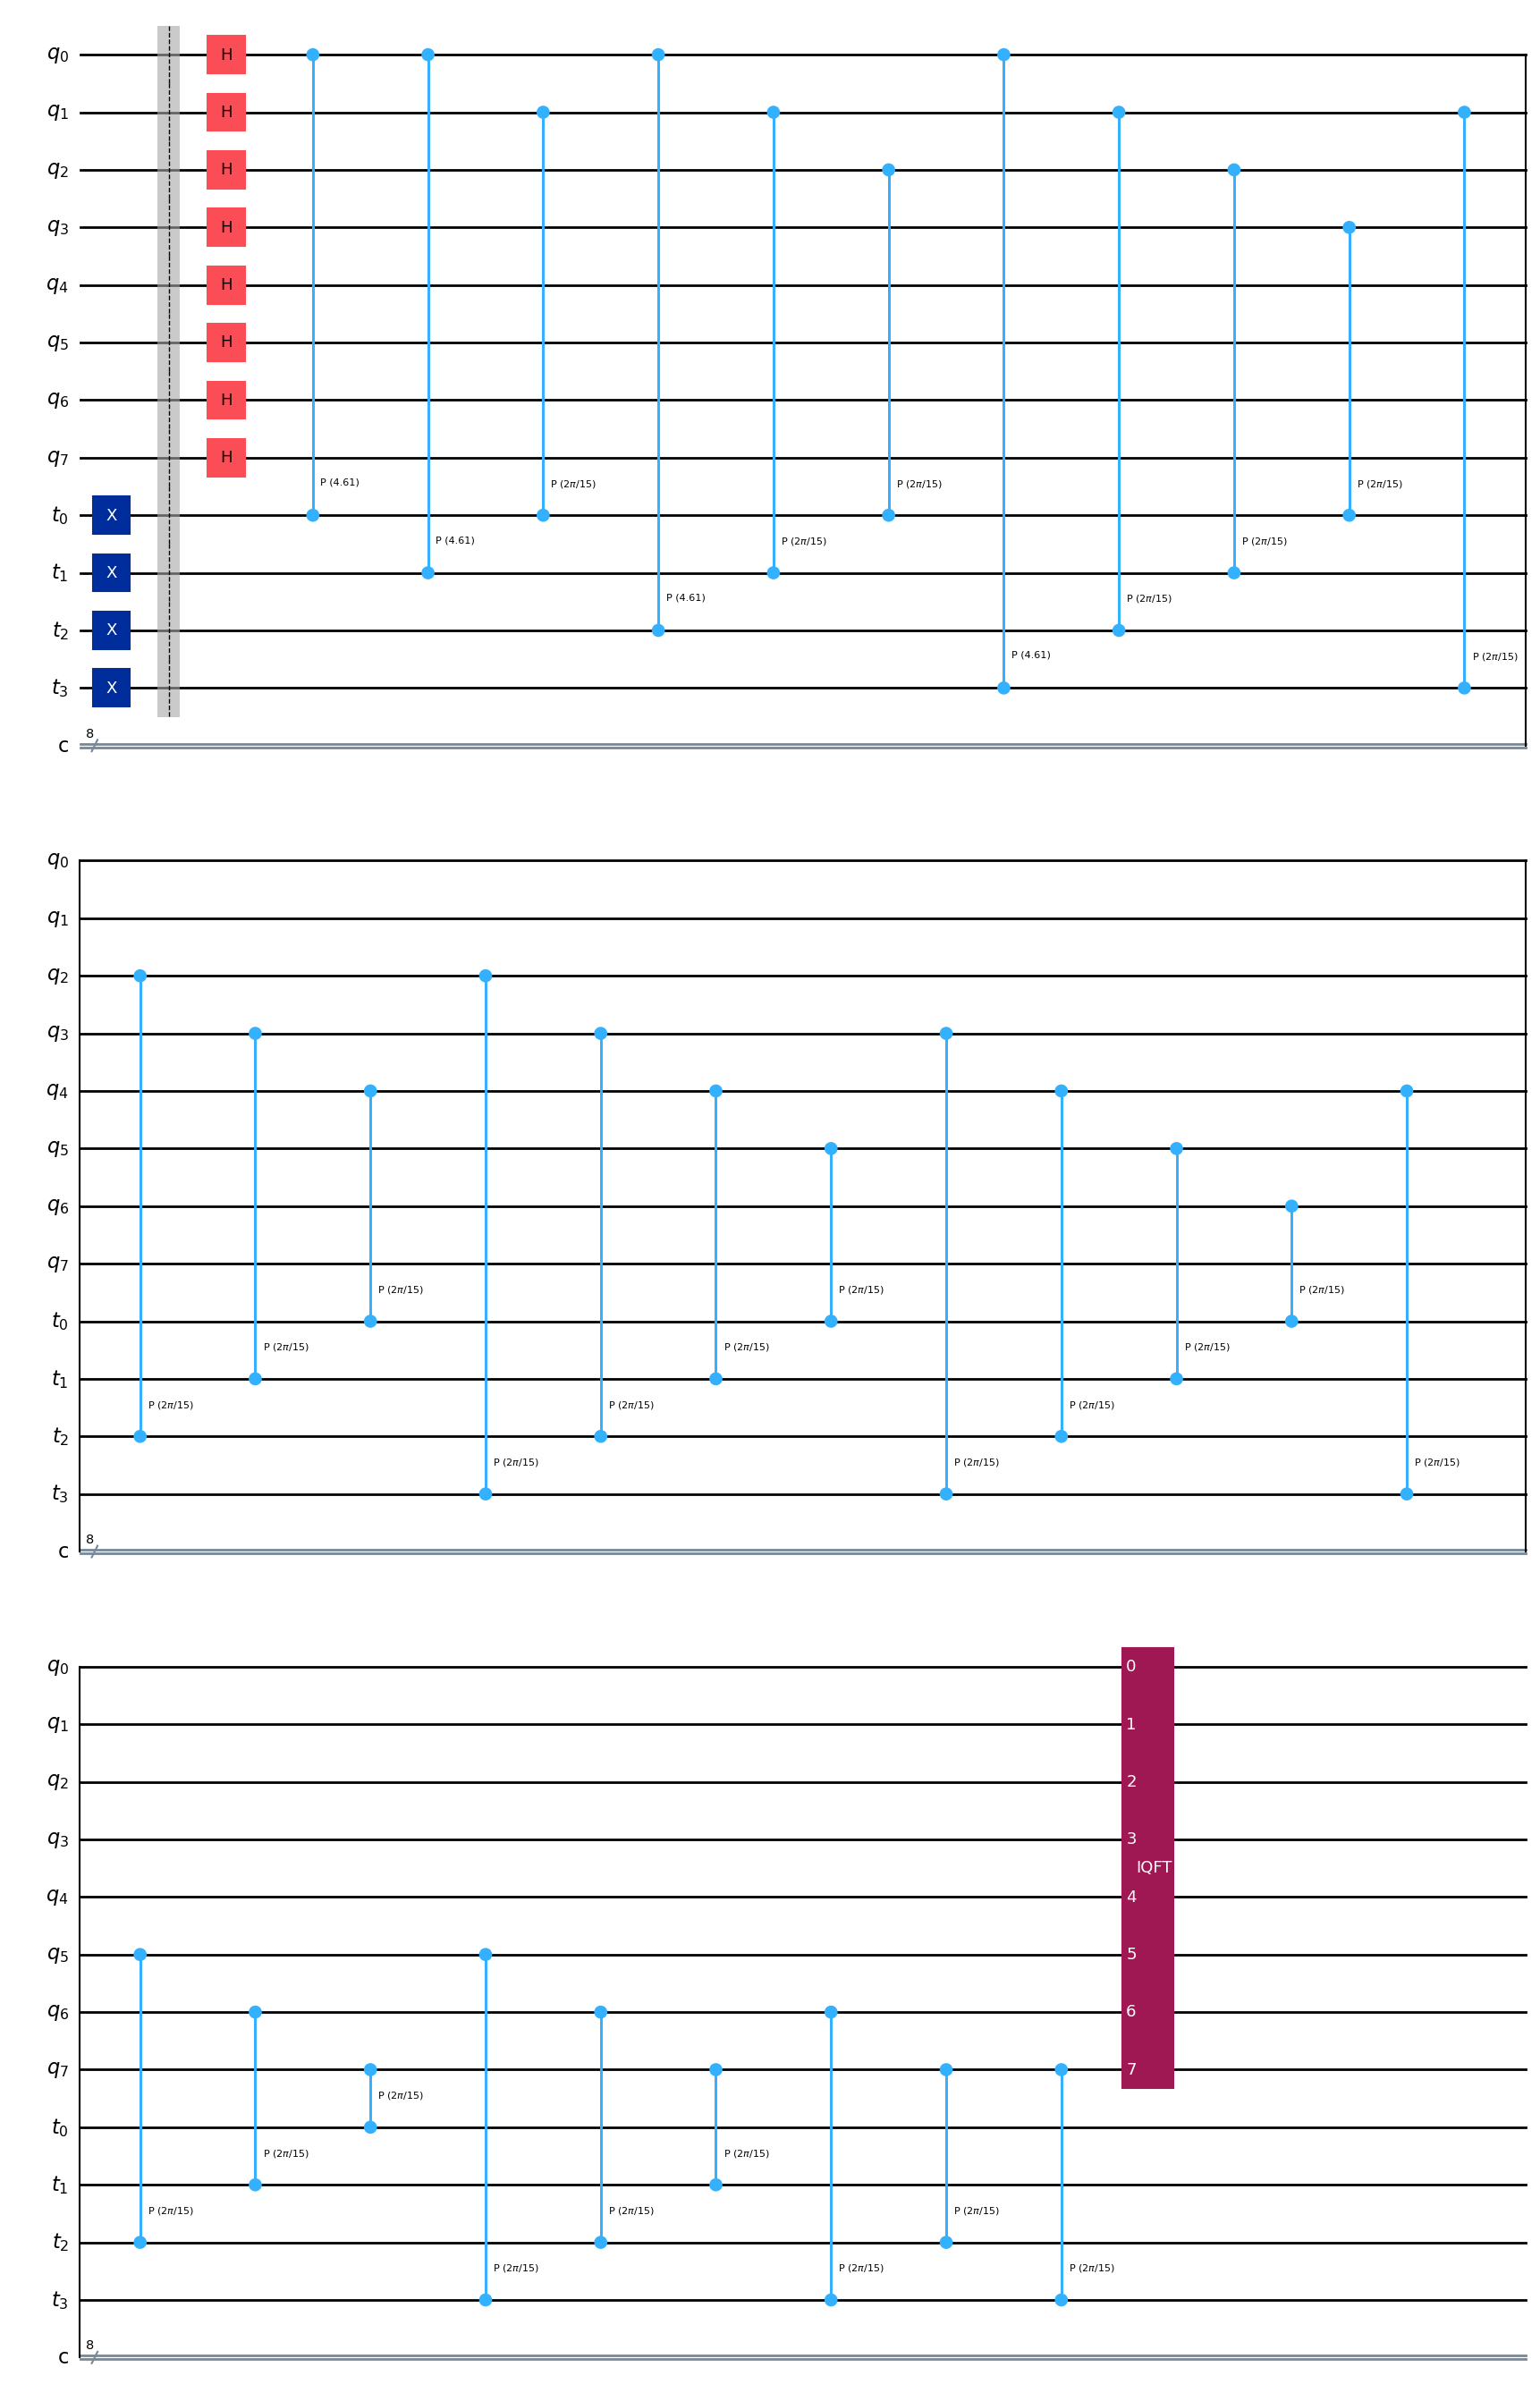

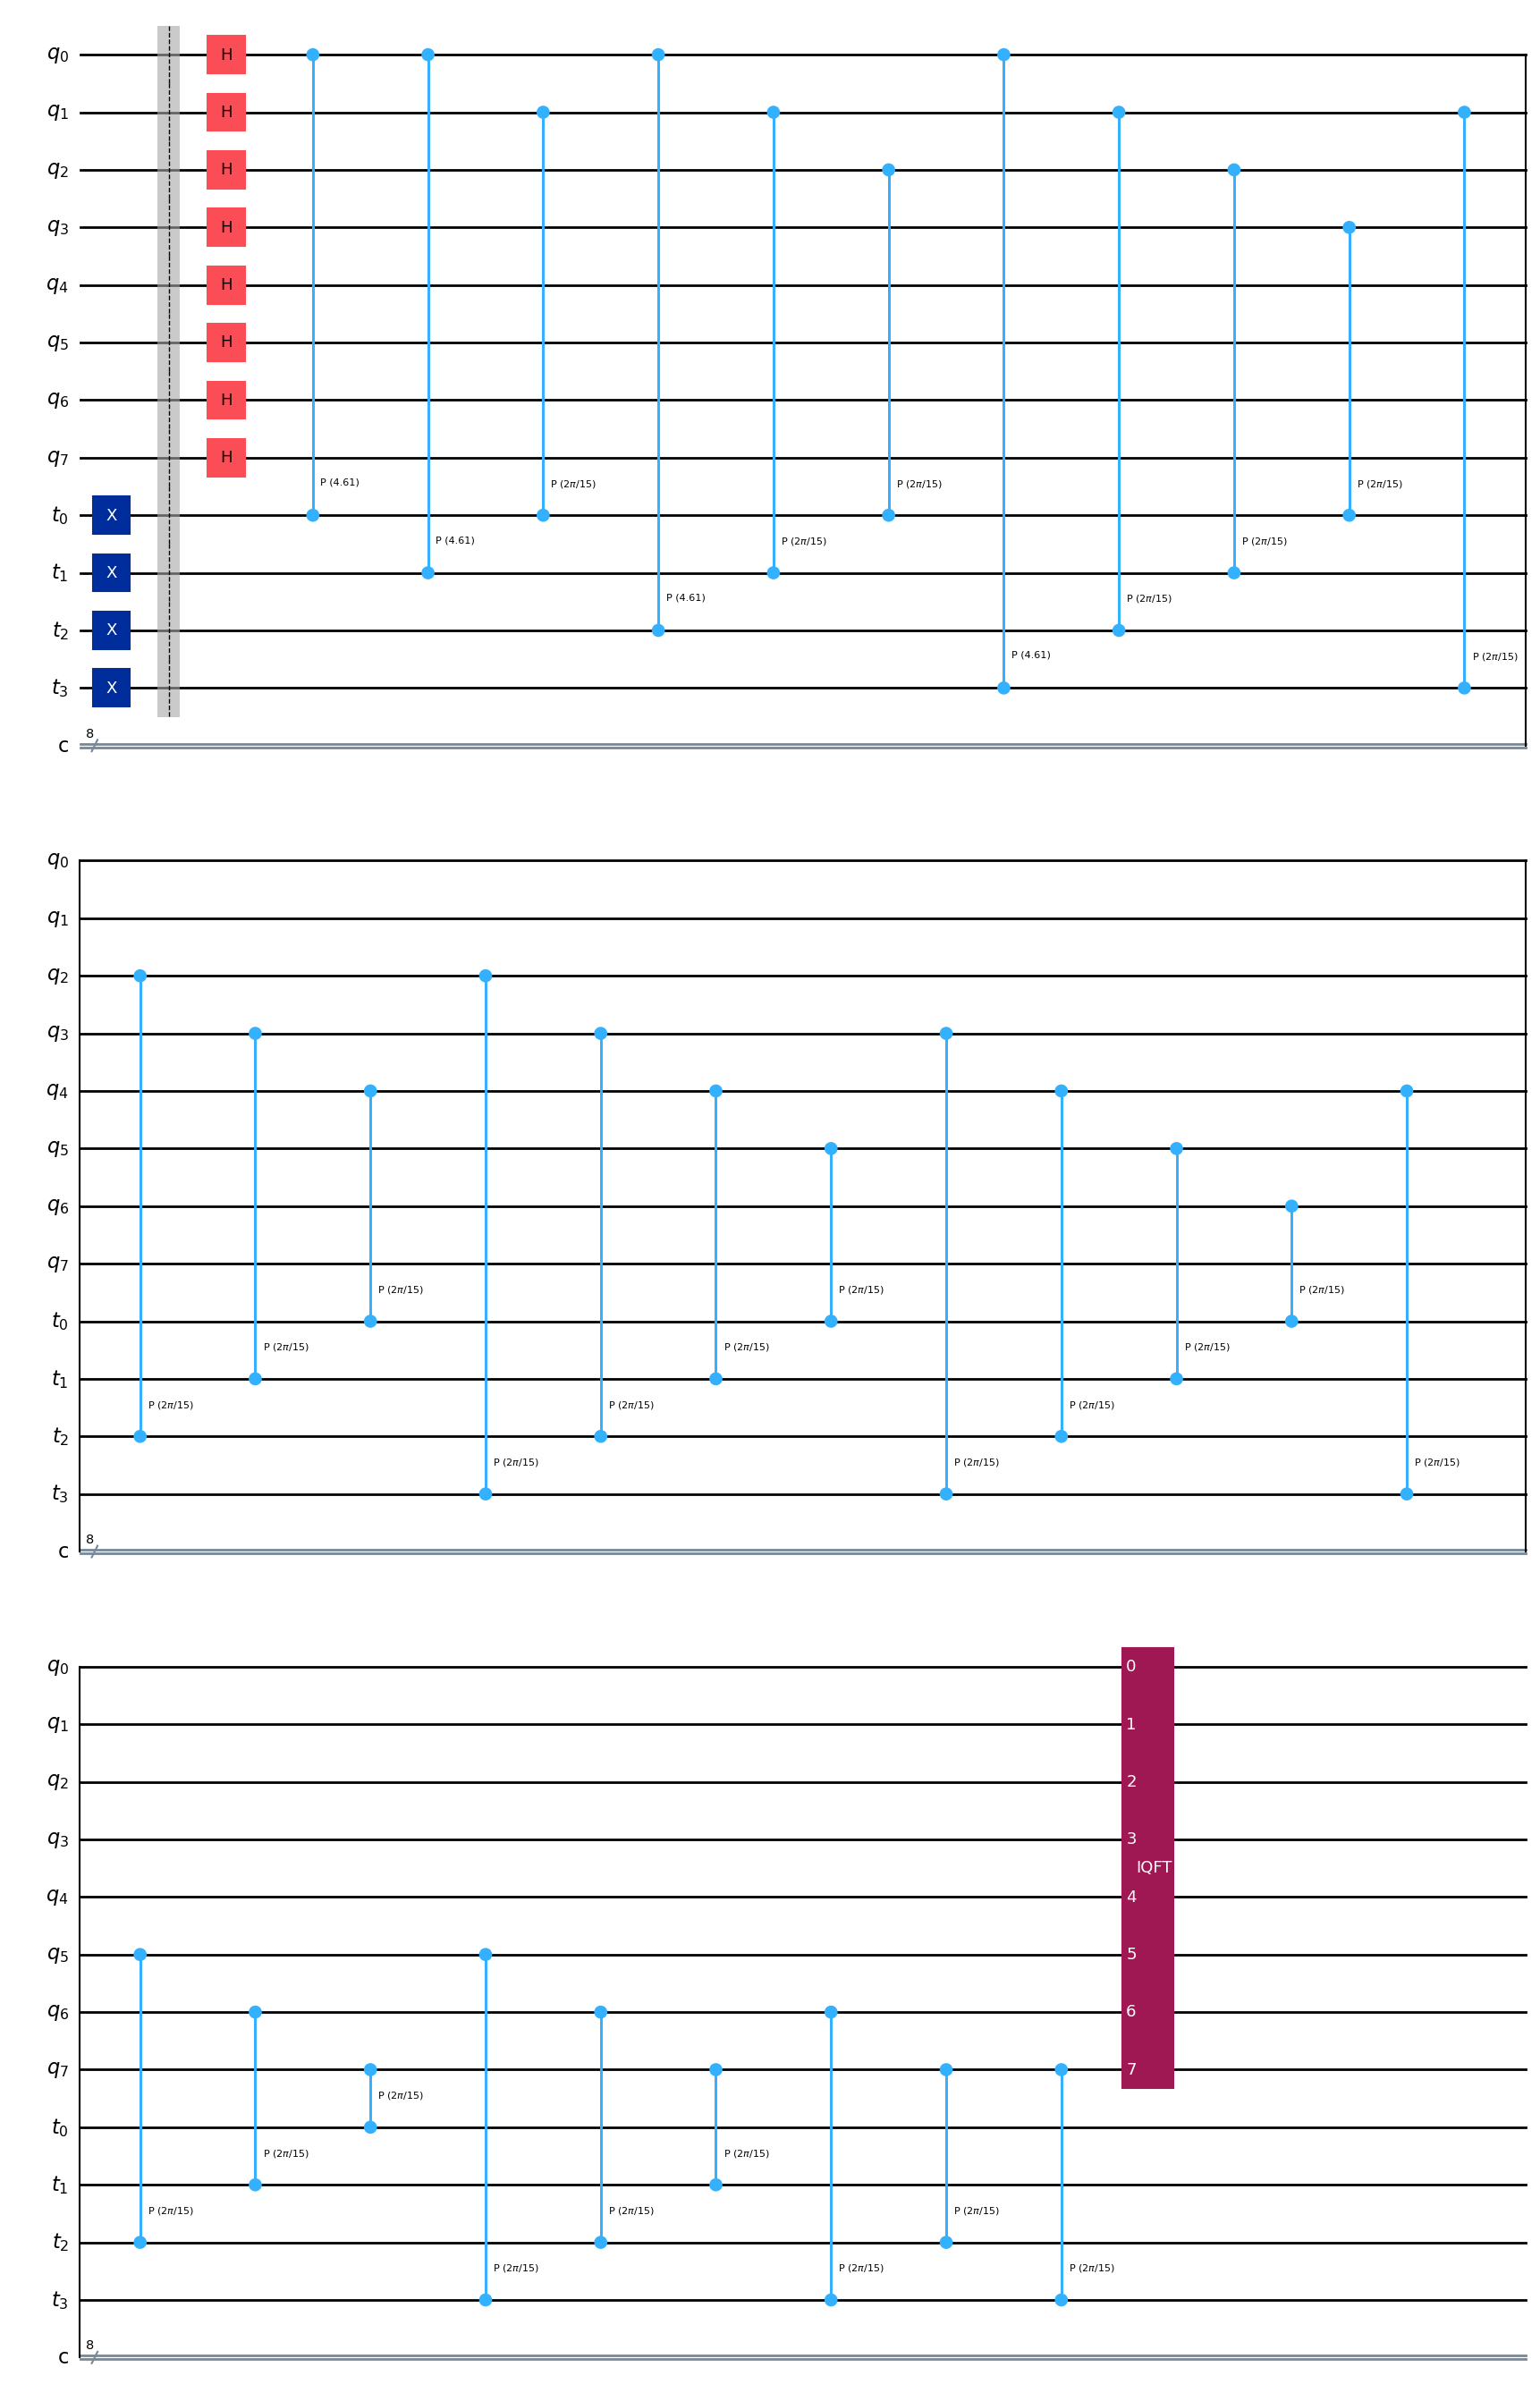

In [397]:
qpe = QuantumCircuit(q, t, c, name="quantum phase estimation")
qpe.x(t) # initialize the target qubits to |1>
qpe.barrier()
qpe.h(q) # apply H-gate to all input qubits
Uf(qpe) # apply modular exponentiation
qpe.append(QFT(2*n, inverse=True), q) # apply the inverse QFT
qpe.draw("mpl")

In [398]:
state = Statevector.from_instruction(qpe)
state.draw("latex")

<IPython.core.display.Latex object>

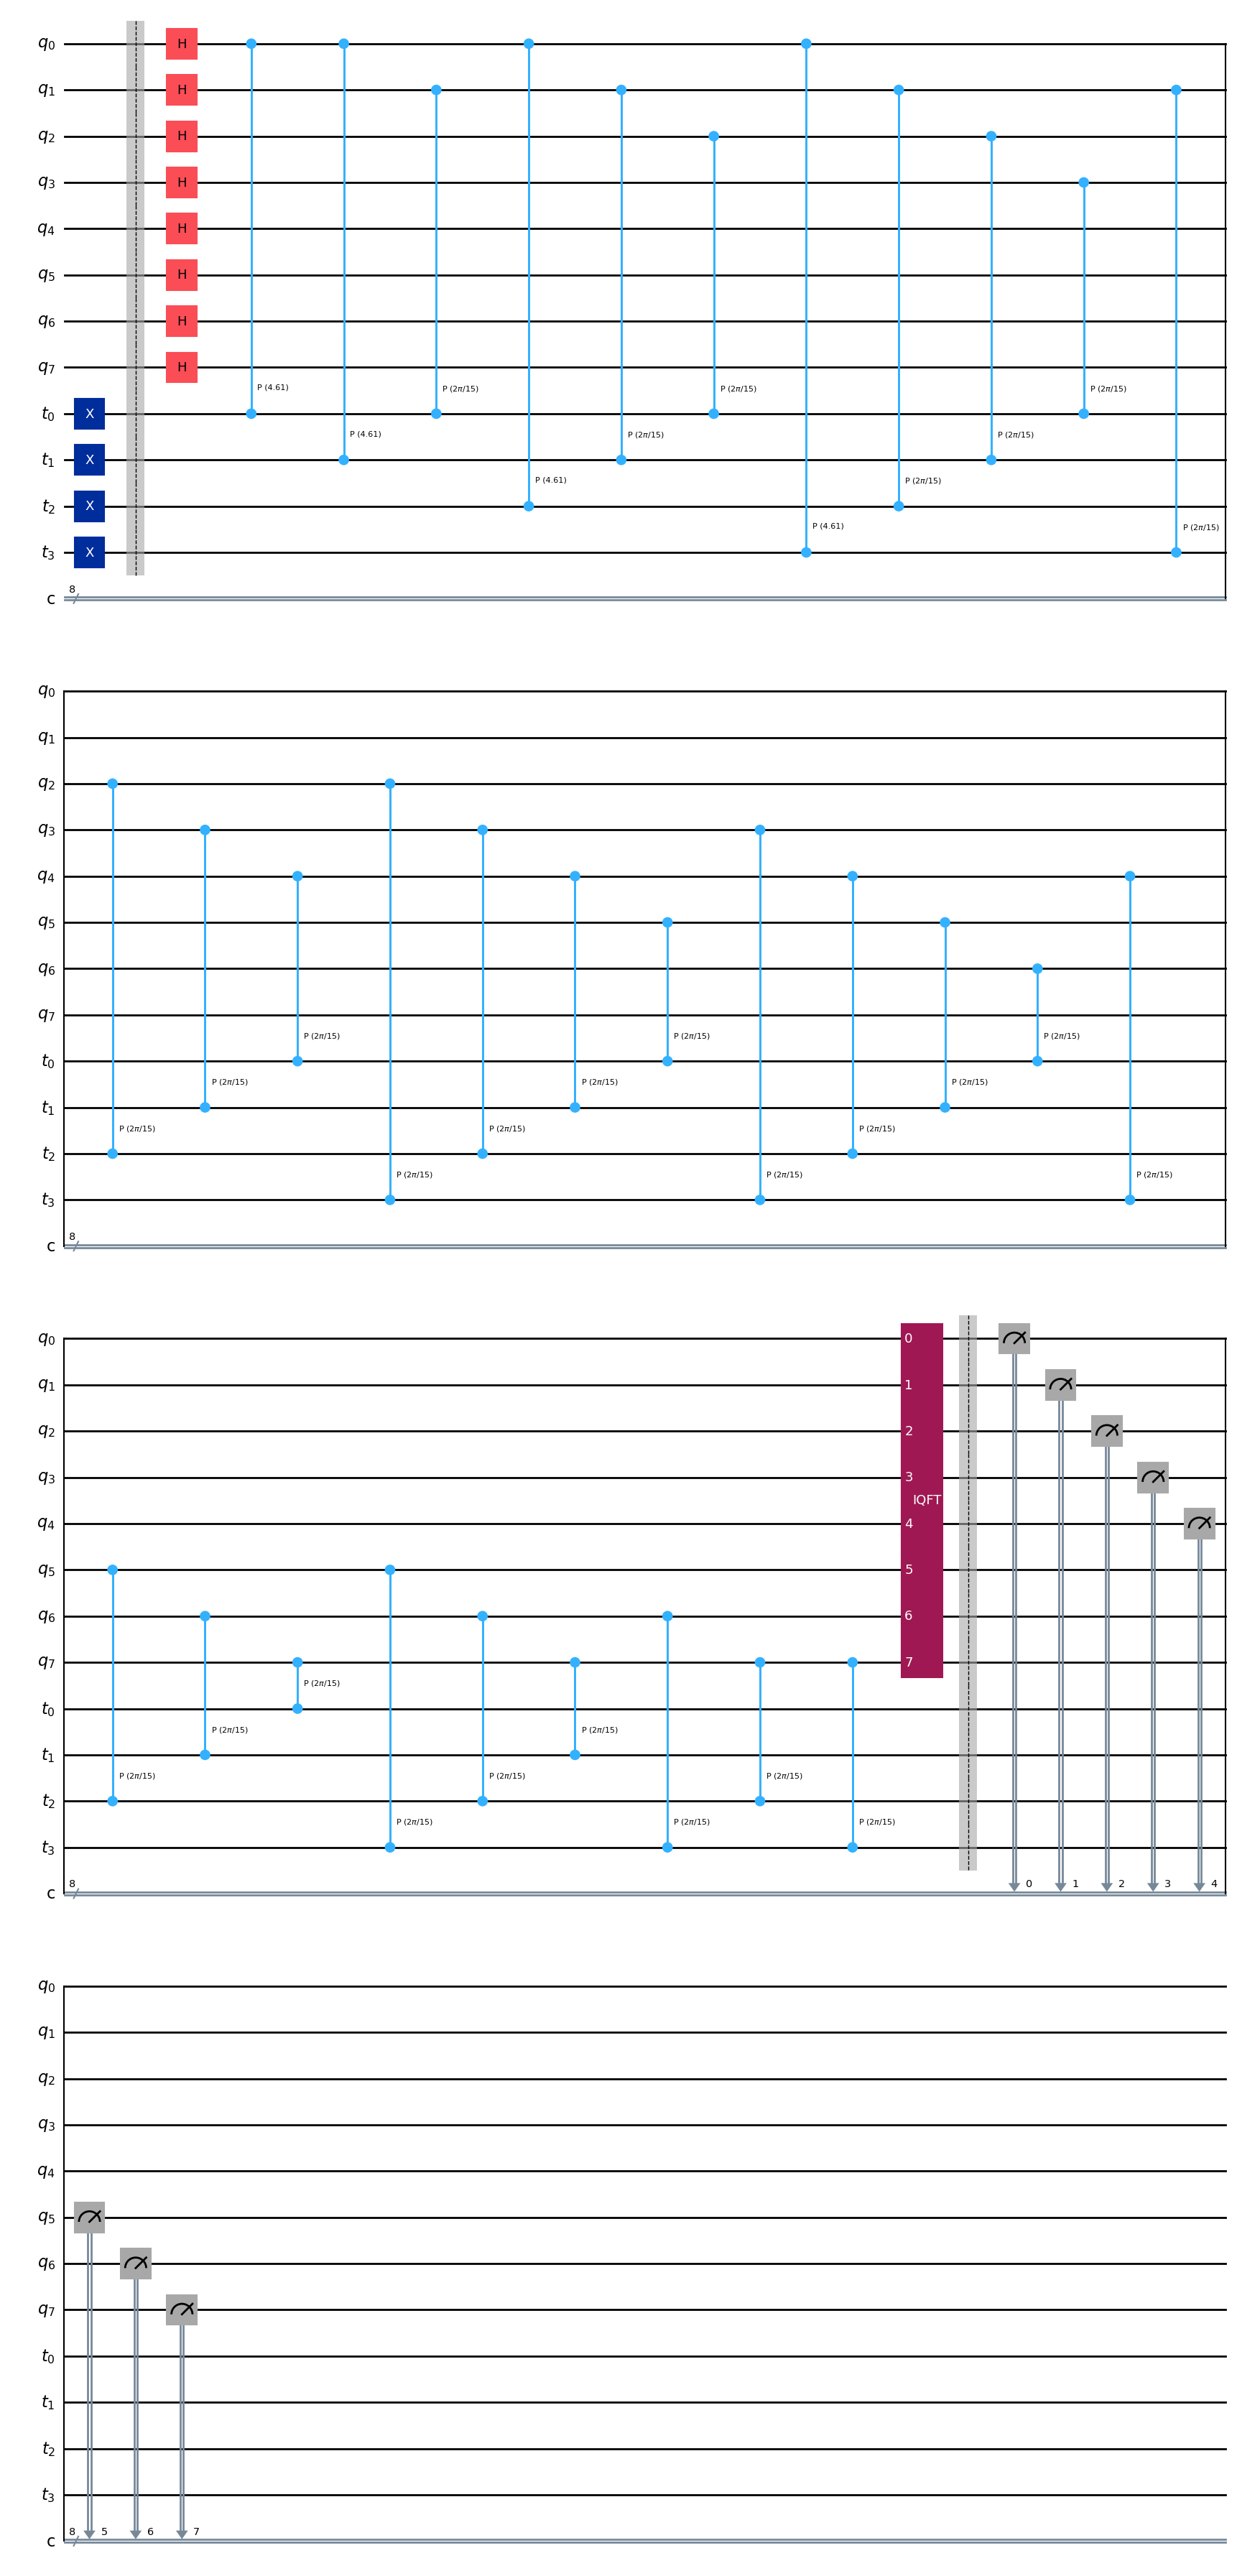

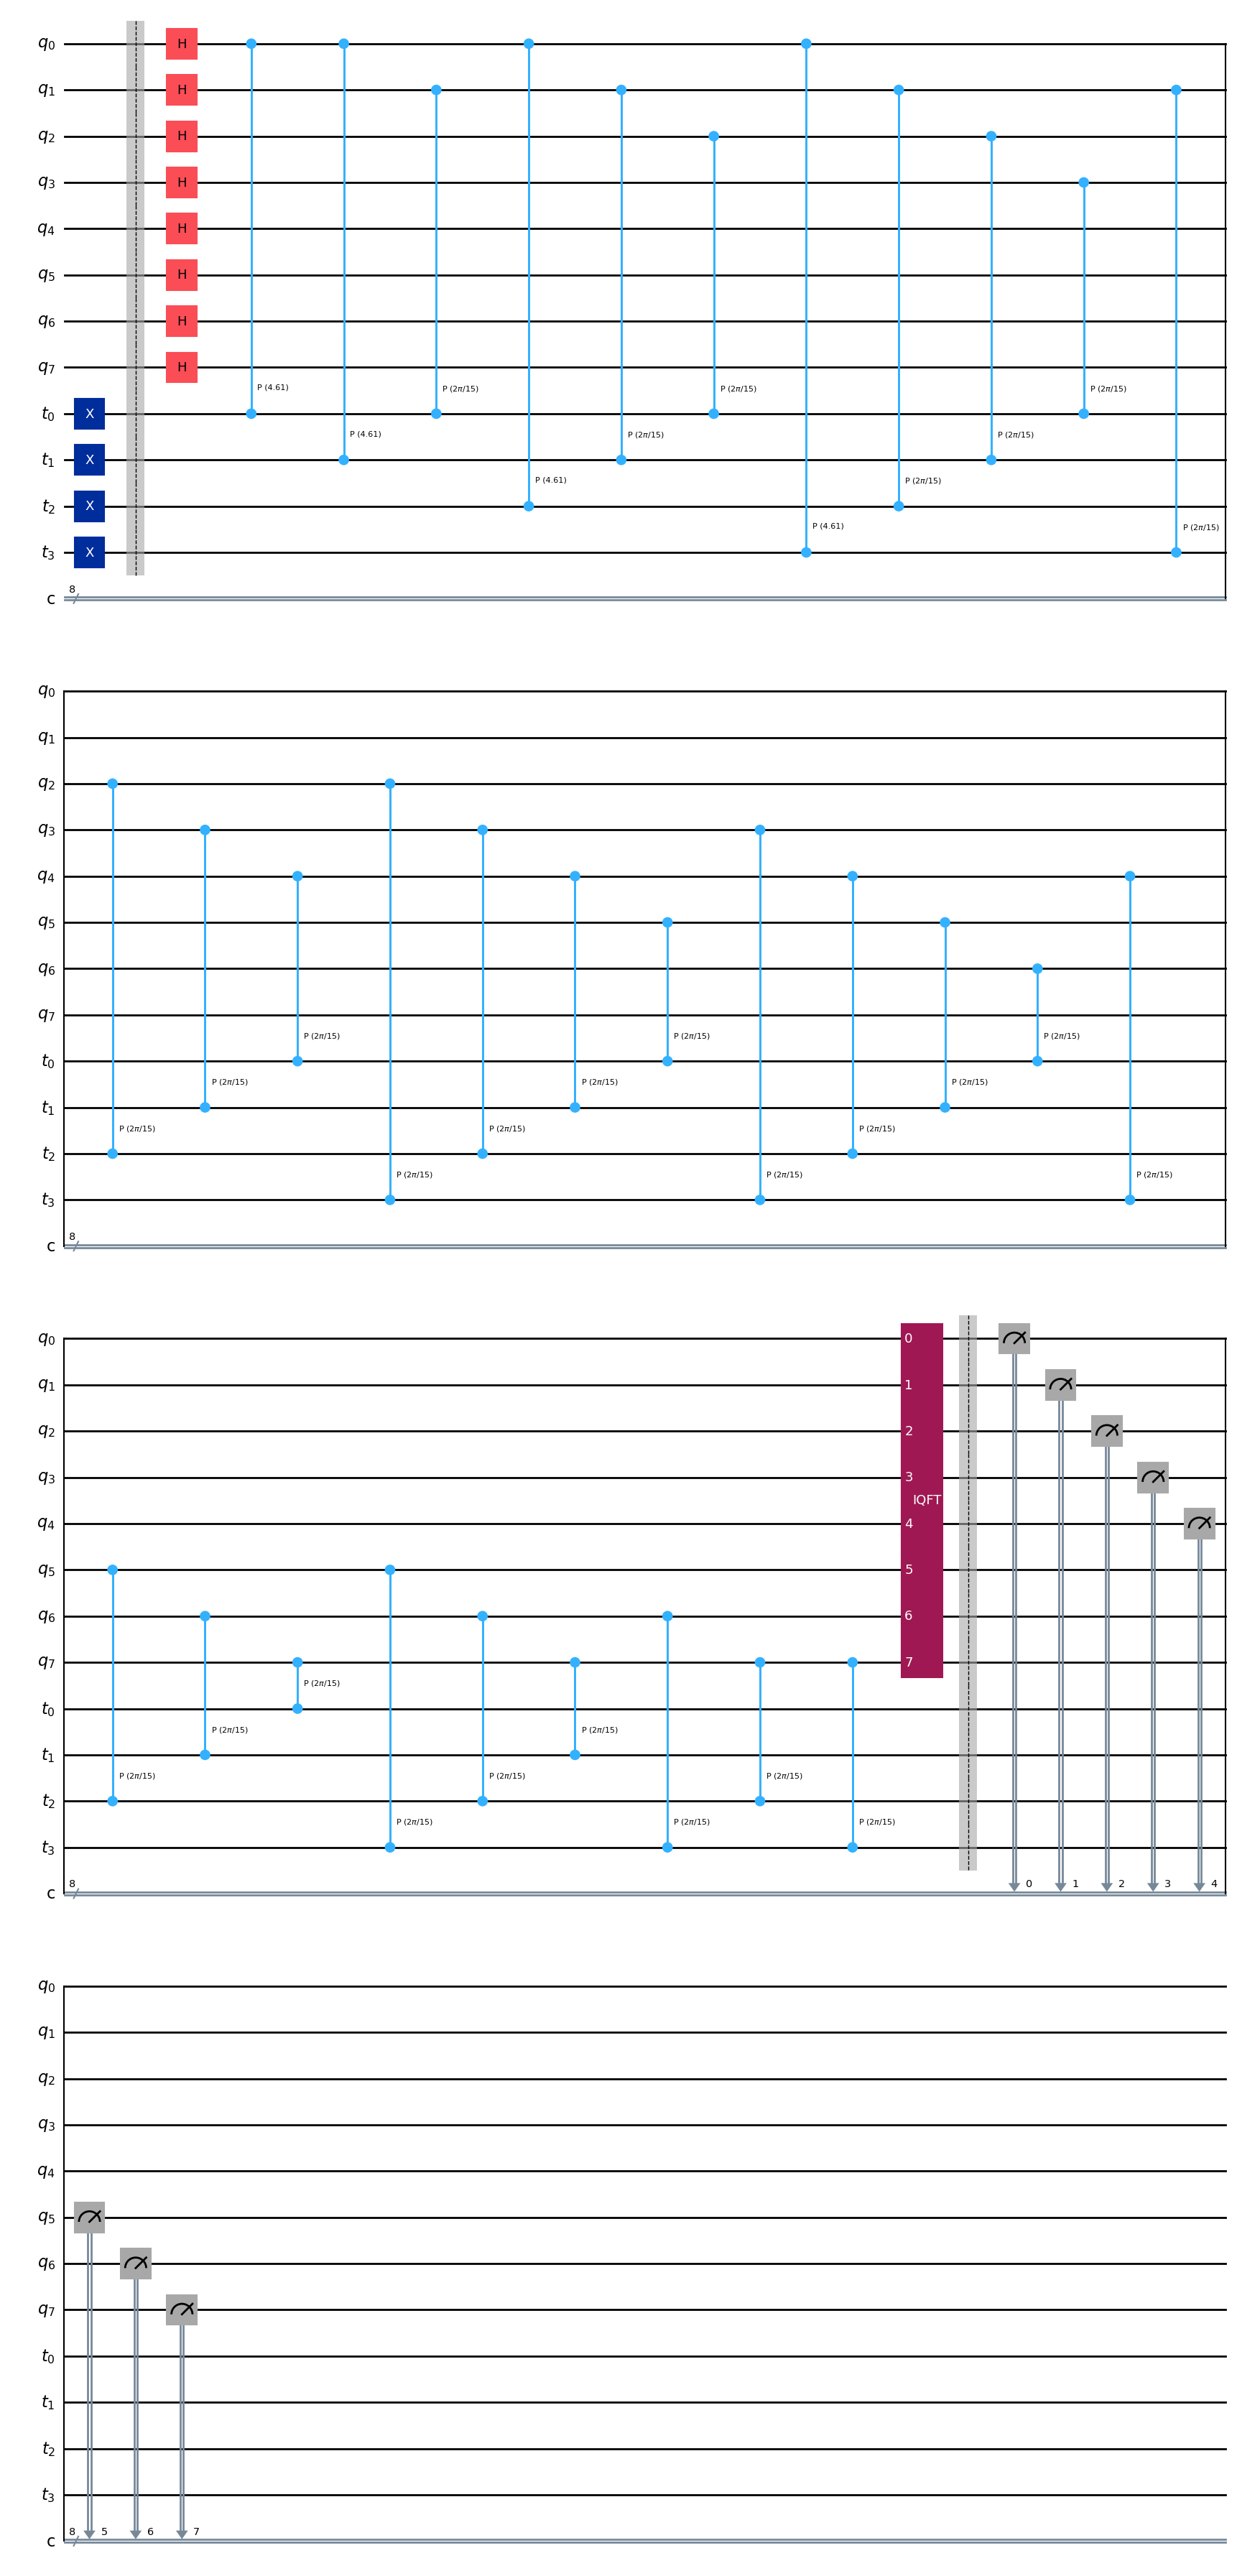

In [399]:
qpe.barrier()
qpe.measure(q, c) # add measurements to the input qubits
qpe.draw("mpl")

In [400]:
backend = Aer.get_backend('qasm_simulator')
compiled = transpile(qpe, backend)
result = backend.run(compiled, shots=1024).result()
counts = result.get_counts()
print(counts)

{'10000100': 1, '00011111': 1, '10100000': 2, '10101001': 8, '01001010': 4, '00001101': 2, '01000000': 1, '11010000': 6, '00010001': 84, '00101001': 15, '10100100': 12, '00010100': 14, '10000101': 1, '00000010': 29, '11000011': 1, '10100010': 18, '11000000': 5, '00000100': 34, '01000100': 8, '01010101': 1, '01000001': 10, '10010001': 18, '11010010': 11, '00001000': 30, '11010001': 22, '10010010': 6, '00001010': 27, '10010100': 2, '10100001': 27, '00100010': 32, '11010100': 1, '10101010': 1, '00010010': 62, '11000101': 14, '11000001': 33, '00001001': 86, '10001001': 15, '01001001': 9, '11010101': 2, '11001010': 14, '00101010': 5, '00100101': 19, '11000100': 25, '00100100': 23, '00000000': 4, '10010000': 3, '11101001': 1, '00000101': 35, '00100001': 47, '00010101': 5, '01010001': 1, '10100101': 13, '00101000': 9, '11000010': 18, '00000001': 33, '01001000': 1, '10000001': 2, '01000010': 14, '10000010': 3, '00010000': 10, '11001000': 15, '10101000': 1, '00100011': 1, '01010010': 3, '110010

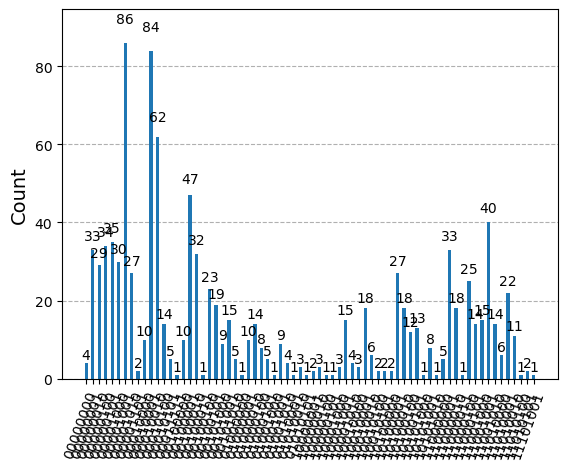

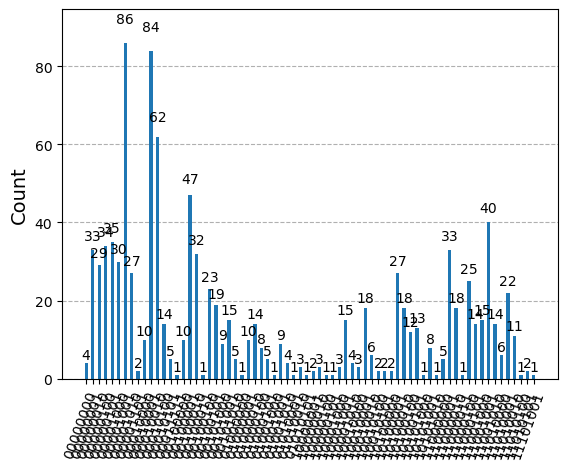

In [401]:
plot_histogram(counts)

#### Classical post-processing to find the factors of N:

This function computes the continued fraction of a rational number x/y. The continued fraction is a list of coefficients ai such that x/y = a0 + 1/(a1 + 1/(a2 + ...)). The function returns the list of coefficients.

In [402]:
def continued_fraction(x, y):
    coefficients = []
    while y != 0:
        a = x // y
        coefficients.append(a)
        x, y = y, x % y
    return coefficients

This function reconstructs the fraction from its continued fraction coefficients. It starts from the last term and iteratively computes the fraction up to the first term.

In [403]:
def reconstruct_fraction(coeffs):
    num, denom = 1, 0  # Start from the last term
    for c in reversed(coeffs):
        num, denom = denom + c * num, num 
    return denom

The following code finds the factors of N using the continued fraction method. It iterates over all possible states and computes the continued fraction coefficients. For each coefficient, it approximates the fraction up to that term and checks if the period is even. If the period is even, it computes the factors p and q. If both p and q are non-trivial factors of N, it stores them with their counts.

In [404]:
factors = {}
r = 0
for state, count in counts.items():
    x = int(state, 2)  # Convert binary to integer
    coeffs = continued_fraction(x, 2**(2*n))  # Get continued fraction coefficients
    for i in range(1, len(coeffs)):
        r = int(reconstruct_fraction(coeffs[:i]))  # Approximate fraction up to i terms
        if r == 0 or r % 2 != 0:  # Skip invalid periods
            continue
        p = gcd(pow(a, r // 2, N) - 1, N)
        q = gcd(pow(a, r // 2, N) + 1, N)
        if p != 1 and q != 1 and p * q == N:
            factors[(p, q)] = count  # Store factors with their counts
print(f"Period r = {r}, Factors = {factors}")

Period r = 15, Factors = {(5, 3): 3}
